# **A EDP do Calor**
   -----------------

Vamos solucionar a EDP homogênea do calor em $ d $ dimensões espaciais:

\begin{align}
     \frac{ \partial u }{ \partial t } &= k \nabla^2 u \\
                     &= k \left(
                            \sum_{i = 1}^{ d } \frac{ \partial^2 u }{ \partial x_{ i }^2 }
                         \right)
,\end{align}

onde $ k \in \mathbb{R} $ e $ u $ é uma função real definida em $ [0, T] \times \mathbb{R}^d $ que safisfaz $ u(0, \cdot) = u_0 $ para alguma $ u_0 : \mathbb{R}^d \to \mathbb{R} $.

Como $ \Omega = \mathbb{R}^d $ nesse caso, temos $ \partial \Omega = \emptyset $ e não há condições de fronteira.
Portanto, nossa perda será calculada apenas com relação à condição inicial e à equação diferencial.

Para tornar viável a amostragem de pontos no domínio da EDP, introuzimos uma constante $ L \in \mathbb{R_{ + }} $ tal que os pontos espaciais serão amostrados uniformemente em $ [-L, L]^d $.

## Imports

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.nn import relu as relu
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import os

## Select where to run this notebook
# os.chdir("/content/drive/MyDrive/Colab Notebooks/simple-dgm")

## Plot sizes
cent = 1/2.54  # Centimeters in inches
plt.rcParams['figure.figsize'] = [30*cent, 20*cent]

## Implement Custom Layers
--------------------------

Aqui implementamos os dois tipos de camadas utilizados na rede DGM:


*   Camadas densas
*   Camadas do tipo Highway/LSTM

Lembrando, esta é a estrutura de uma camada do tipo Highway, que recebe como input o vetor $ \vec{ \boldsymbol{ x } } = (t, \boldsymbol{ x } ) $ e o output $ S^{ \ell } $ da camada anterior:
\begin{align}
    Z^{ \ell } &= \sigma \left(
        U^{ z, \ell } \boldsymbol{ \vec{ x } } + W^{ z, \ell } S^{ \ell } + b^{ z, \ell }
    \right) \\
    G^{ \ell } &= \sigma \left(
        U^{ g, \ell } \boldsymbol{ \vec{ x } } + W^{ g, \ell } S^{ \ell } + b^{ g, \ell }
    \right) \\
    R^{ \ell } &= \sigma \left(
        U^{ r, \ell } \boldsymbol{ \vec{ x } } + W^{ r, \ell } S^{ \ell } + b^{ r, \ell }
        \right) \\
    H^{ \ell } &= \sigma \left(
        U^{ h, \ell } \boldsymbol{ \vec{ x } } + W^{ h, \ell } \left(
            S^{ \ell } \odot R^{ \ell }
        \right) + b^{ h, \ell }
    \right) \\
    S^{ \ell + 1 } &= \left(
            \boldsymbol{1} - G^{ \ell }
        \right) \odot H^{ \ell } + Z^{ \ell } \odot S^{ \ell }
\end{align}



In [2]:
""" Implements the Highway-like layers described in the DGM article, as well as
a custom Dense Layer.
"""

# Highway layer used in DGM (see Figure 5.3 and set of equations on p. 45)
class HighwayLayer(tf.keras.layers.Layer):

    def __init__(self, output_dim, input_dim, trans1="tanh", trans2="tanh"):
        """
        Parameters
        ----------
        input_dim: int
            Dimensionality of input data.
        output_dim: int
            Number of outputs for Highway layers.
        trans1, trans2: string
            Activation functions used inside the layer.
            Must be one of: "tanh" (default), "relu" or "sigmoid".

        Returns
        -------
            Customized Keras layer object used as intermediate layers in DGM.
        """
        super(HighwayLayer, self).__init__()

        # Add properties for layer including activation functions
        # used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim

        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid

        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.relu

        ## Define Highway layer parameters (use Xavier initialization)

        # U vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_weight("Uz",
                                  shape=[self.input_dim, self.output_dim],
                                  initializer=tf.initializers.GlorotUniform(),
                                  dtype=tf.float32)
        self.Ug = self.add_weight("Ug",
                                  shape=[self.input_dim ,self.output_dim],
                                  initializer=tf.initializers.GlorotUniform(),
                                  dtype=tf.float32)
        self.Ur = self.add_weight("Ur",
                                  shape=[self.input_dim, self.output_dim],
                                  initializer=tf.initializers.GlorotUniform(),
                                  dtype=tf.float32)
        self.Uh = self.add_weight("Uh",
                                  shape=[self.input_dim, self.output_dim],
                                  initializer=tf.initializers.GlorotUniform(),
                                  dtype=tf.float32)

        # W vectors (weighting vectors for output of previous layer)        
        self.Wz = self.add_weight("Wz", shape=[self.output_dim, self.output_dim],
                                  initializer=tf.initializers.GlorotUniform(),
                                  dtype=tf.float32)
        self.Wg = self.add_weight("Wg", shape=[self.output_dim, self.output_dim],
                                  initializer=tf.initializers.GlorotUniform(),
                                  dtype=tf.float32)
        self.Wr = self.add_weight("Wr", shape=[self.output_dim, self.output_dim],
                                  initializer=tf.initializers.GlorotUniform(),
                                  dtype=tf.float32)
        self.Wh = self.add_weight("Wh", shape=[self.output_dim, self.output_dim],
                                  initializer=tf.initializers.GlorotUniform(),
                                  dtype=tf.float32)

        # Bias vectors
        self.bz = self.add_weight("bz", shape=[1, self.output_dim])
        self.bg = self.add_weight("bg", shape=[1, self.output_dim])
        self.br = self.add_weight("br", shape=[1, self.output_dim])
        self.bh = self.add_weight("bh", shape=[1, self.output_dim])


    def call(self, S, X):
        """ Compute output of a HighwayLayer for a given inputs S, X.

        Parameters
        ---------
            S: tf.Tensor
                Output of previous layer.
            X: tf.Tensor
                Data input.
        Returns
        -------
            Customized Keras layer object used as intermediate layers in DGM.
        """
        # Compute components of Highway layer output (note H uses a
        # separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X, self.Uz),
                                      tf.matmul(S, self.Wz)),
                               self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X, self.Ug),
                                      tf.matmul(S, self.Wg)),
                               self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X, self.Ur),
                                      tf.matmul(S, self.Wr)),
                               self.br))
        H = self.trans2(tf.add(tf.add(tf.matmul(X, self.Uh),
                                      tf.matmul(tf.multiply(S, R), self.Wh)),
                               self.bh))
        # Compute Highway layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G),
                                               G),
                                   H),
                       tf.multiply(Z, S))
        return S_new

class DenseLayer(tf.keras.layers.Layer):

    def __init__(self, output_dim, input_dim, transformation=None):
        """
        Parameters
        ----------
        input_dim: int
            Dimensionality of input data.
        output_dim: int
            Number of outputs for dense layer.
        Transformation: string
            Activation function used inside the layer.
            Using None is equivalent to the identity map.

        Returns
        ------
        S: tf.Tensor
            Layer output.
        """
        super(DenseLayer,self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim

        ## Define dense layer parameters (use Xavier initialization)

        # W vectors (weighting vectors for output of previous layer)
        self.W = self.add_weight("W",
                                 shape=[self.input_dim, self.output_dim],
                                 initializer=tf.initializers.GlorotUniform(),
                                 dtype=tf.float32)

        # Bias vectors
        self.b = self.add_weight("b", shape=[1, self.output_dim])

        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation


    def call(self, X):
        """ Compute output of a Dense layer for a given input X.

        Parameters
        ---------
        X: tf.Tensor
            Data input.
        Returns
        -------
        S: tf.Tensor
            Layer output.
        """
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W),
                   self.b)

        if self.transformation:
            S = self.transformation(S)

        return S


## Implement DiffusionPDE class
-------------------------------

Criamos essa classe para armazenar tudo relacionado à EDP: número de dimensões espaciais, domínio, solução, condição inicial e a própria equação.

A ideia é que a classe represente um conjunto de EDPs da forma
\begin{align}
    \frac{ \partial u }{ \partial t} &= w_{ 1 } \frac{ \partial^2 u }{ \partial x_1^2 } + \cdots + w_{ d } \frac{ \partial^2 u }{ \partial x_d^2 } \\
    &= \Big\langle \boldsymbol{ w }, \frac{ \partial^2 u }{ \partial \boldsymbol{ x^2 } } \Big\rangle
,\end{align}
onde $ \boldsymbol{ w } \in \mathbb{ R }^d $ é um vetor de pesos e
\begin{equation}
    \frac{ \partial^2 u }{ \partial \boldsymbol{ x }^2 } =
    \left(
        \frac{ \partial^2 u }{ \partial x_1^2 },
        \dots,
        \frac{ \partial^2 u }{ \partial x_d^2 }
    \right)
    \in \mathbb{ R }
.\end{equation}

Com isso, para armazenar a equação, precisamos apenas do vetor $ \boldsymbol{ w } $, o qual chamamos de `kernel`.

Observe que a EDP do calor é obtida tomando $ \boldsymbol{ w } = k \cdot \boldsymbol{ 1 } $.

In [3]:
""" Implements the DiffusionPDE class

    TODO
    ----
        Separate PDE and DiffusionPDE classes
"""

class DiffusionPDE:
    """ This object represents a diffusion PDE, with its solution and equation.

    The equation is assumed to be of the form

        u_t = <laplacian_vec(u), kernel> + f(t, x),

    where `kernel` is a tensor of shape (`dim`, 1) and `laplacian_vec(u)`
    has shape (1, `dim`) and is the diagonal of the Hessian matrix for u.
    f is the independent term.

    The solution is assumed to be defined on a hypercube.

    Parameters
    ----------
    dim: int
        Spacial dimension of the PDE.
    t_max: float > 0
        Maximum time.
    domain: tf.Tensor
        Tensor of shape (`dim`, 2). Represents the hypercube on
        which the solution is defined.
    solution: function
        Solution to the equation. Must be of the form u(t, x), where x
        is a tensor of shape (`dim`,).
    independent_term: function
        Independent term of the PDE. Must be of the form f(t, x), where
        x is a tensor of shape (`dim`,).
    initial_cond: function
        Function for `t = 0`. Must be of the form f(x), where x is a tensor
        of shape (`dim`,).
    boundary_cond: function
        Function for terminal values of x. Must be of the form f(t, x),
        where x is a tensor of shape (`dim`,).
    kernel: tf.Tensor
        Tensor with shape (`dim`,).
    name: string
        Give your PDE a descriptive name!
    """

    def __init__(self, dim, t_max, domain, solution, initial_cond, kernel, name):
        self.dim = dim
        self.t_max = t_max
        self.domain = domain
        self.solution = solution
        self.initial_cond = initial_cond
        self.kernel = kernel
        self.name = name


## Implement DGM model
   -------------------

   Implementamos a classe `DGMNet`, que herda da classe `tf.keras.Model`.

   A ideia é tornar seu uso o mais parecido possível com modelos mais tradicionais, portanto, sobrescrevemos o método `fit` para que ele realize o loop de treino customizado do DGM, baseado em *sampling stages*.


In [4]:
""" CLASS DEFINITIONS FOR NEURAL NETWORKS USED IN DEEP GALERKIN METHOD
"""


# Neural network architecture used in DGM - modification of Keras Model class

class DGMNet(tf.keras.Model):

    def __init__(self, layer_width, n_layers, pde, final_trans=None):
        """
        Parameters
        ----------
        layer_width: int
            Number of nodes in each hidden leayer.
        n_layers: int
            Number of intermediate Highway layers.
        final_trans: string
            Transformation used in final layer.
            Its value must be either `"relu"` or `"tanh"`.
        pde: DiffusionPDE
            Object representing the PDE to be numerically solved.

        Returns
        -------
            Customized Keras model object representing DGM neural network.
        """
        super(DGMNet, self).__init__()

        # The PDE our model will solve
        self.pde = pde

        # Retrieve spacial input dimension from pde
        self.input_dim = pde.domain.shape[0]

        # Define initial layer as fully connected 
        # NOTE: to account for time inputs we use input_dim+1
        # as the input dimensionality
        self.initial_layer = DenseLayer(layer_width,
                                        self.input_dim+1,
                                        transformation="tanh")
        # define intermediate Highway layers
        self.n_layers = n_layers
        self.HighwayLayerList = []

        for _ in range(self.n_layers):
            self.HighwayLayerList.append(HighwayLayer(layer_width, self.input_dim+1))

        # Define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(1, layer_width, transformation=final_trans)

        # NOTE: The transformation tensors used in the self.sampler method
        # must know the sample and batch sizes at the time of their creation, so
        # they are created inside the self.create_sampling_tensors method,
        # which is called by the self.fit method

    def create_sampling_tensors(self, sample_size, batch_size):
        """ Create transformation Tensors used in sampler.

        Creates tensors as class atributes, which are used in the `sampler`
        method.

        Parameters
        ---------
        sample_size: int
            Size of each sample to be drawn from the PDE domain.
        batch_size: int
            Size of each mini-bach for SGD.
        """

        ## Build translating and scaling tensors used to transform samples from
        ## the uniform distribution
        self.sampler_translate = np.ones(shape=(sample_size,
                                                self.input_dim)).astype(np.float32)
        self.sampler_scale = np.ones(shape=(sample_size,
                                            self.input_dim)).astype(np.float32)
        for i in range(self.input_dim):
            self.sampler_translate[:, i] *= self.pde.domain[i, 0]
            self.sampler_scale[:, i] *= self.pde.domain[i, 1] - self.pde.domain[i, 0]

    def sampler(self, sample_size, batch_size):
        """ Samples spacial and temporal points on the PDE domain.

        Samples points on the interior of the domain, on the spacial domain
        border and on initial time.

        Parameters
        ---------
        sample_size: int
            Size of each sample to be drawn from the PDE domain.
        batch_size: int
            Size of each mini-bach for SGD.

        Returns
        ------
        dataset: tf.data.Dataset
            A dataset which contains batches of samples.
            Each sample is a tuple with six elements.
            Three of them correspond to time arrays, and three to spacial arrays.
            The time arrays have shape `(batch_size, 1)` and the spacial arrays
            have shape `(batch_size, self.input_dim)`.
        """
        ## Sample points in the interior of sample space

        t_interior = np.random.uniform(low=0, high=self.pde.t_max,
                                       size=(sample_size, 1)).astype(np.float32)
        # We sample spacial points uniformly in [0, 1] and then transform them
        # to fit the PDE domain
        x_interior = np.random.uniform(size=(sample_size,
                                             self.input_dim)).astype(np.float32)
        # Transform spacial sample
        x_interior = x_interior * self.sampler_scale + self.sampler_translate


        ## Sample points in initial time

        t_initial = np.zeros(shape=(sample_size, 1)).astype(np.float32)
        # We sample spacial points uniformly in [0, 1] and then transform them
        # to fit the PDE domain
        x_initial = np.random.uniform(size=(sample_size,
                                            self.input_dim)).astype(np.float32)
        # Transform spacial samples
        x_initial = x_initial * self.sampler_scale + self.sampler_translate


        ## Create dataset

        dataset = tf.data.Dataset.from_tensor_slices((t_interior,
                                                      x_interior,
                                                      t_initial,
                                                      x_initial)).batch(batch_size)

        return dataset

    @tf.function
    def compute_loss(self):
        """ Computes the loss function on a given batch.

        Computes the sum of the losses given by the differential equation,
        the boundary conditions and the initital conditions.

        Returns
        ------
        L1: float32
            Loss corresponding to the differential equation.
        L2: float32
            Loss corresponding to initial conditions.
        """
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.t_interior)
            tape.watch(self.x_interior)
            V = self.call(self.t_interior, self.x_interior)
            V_s = tape.gradient(V, self.x_interior)

        # Second gradient doesn't need to be taped,
        # neither does the time derivative
        V_t = tape.gradient(V, self.t_interior)

        # This is not a Hessian matrix, rather, it is its diagonal
        V_ss = tape.gradient(V_s, self.x_interior)


        ## Compute the differential operator specified by the PDE

        diff_V = (V_t - tf.matmul(V_ss, self.pde.kernel))
        L1 = tf.reduce_mean(tf.square(diff_V))


        ## Compute loss on initial time

        # We assume the initial condition function can be applied to tensors

        initial_V = self.call(self.t_initial, self.x_initial)
        initial_sol = tf.reshape(
                        self.pde.initial_cond(self.x_initial),
                        self.t_initial.shape
                      )
        L2 = tf.reduce_mean(tf.square(initial_V - initial_sol))

        return L1, L2

    @tf.function
    def train_step(self):
        """ Applies changes to model weights given by a single batch.

        Returns
        -------
        L1 : float32
            Loss corresponding to the differential equation.
        L2: float32
            Loss corresponding to initial conditions.
        """
        with tf.GradientTape() as tape:
            L1, L2 = self.compute_loss()
            L = L1 + L2
        grads = tape.gradient(L, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return L1, L2

    def fit(self, learning_rate_fn, epochs,
            batch_size=2**6, sample_size=2**9, sampling_stages=int(5e5),
            initial_sample=0, path=None):
        """ Fits the DGMNet to its PDE.

        Executes the training loop.

        Parameters
        ----------
        learning_rate_fn: output of tf.keras.optimizers.schedules.PiecewiseConstantDecay
            A 1-arg callable learning rate schedule that takes the current
            optimizer step and outputs the decayed learning rate, a scalar
            Tensor of the same type as the boundary tensors.
        epochs: int
            Number of times to iterate through a single sample drawn from the
            PDE domain with `sampler`.
        sample_size: int
            Size of each sample to be drawn from the PDE domain.
        batch_size: int
            Size of each mini-bach for SGD.
        sampling_stages: int
            Number of times to sample using `sampler`.
        path: string
            Path to save the model
        """

        # Create input varibles used in training
        t_interior = np.zeros(shape=(batch_size, 1))
        x_interior = np.zeros(shape=(batch_size, self.input_dim))
        t_initial = t_interior
        x_initial = x_interior

        self.t_interior = tf.Variable(t_interior, trainable=False, dtype=np.float32)
        self.x_interior = tf.Variable(x_interior, trainable=False, dtype=np.float32)
        self.t_initial = tf.Variable(t_initial, trainable=False, dtype=np.float32)
        self.x_initial = tf.Variable(x_initial, trainable=False, dtype=np.float32)

        # Create step variable
        step = tf.Variable(0, trainable=False)

        # Create sampling tensors
        self.create_sampling_tensors(sample_size=sample_size, batch_size=batch_size)

        ## Execute training loop

        sample_avg_time = 0
        epoch_avg_time = 0
        sample_counter = 0
        epoch_counter = 0

        for s in range(initial_sample, sampling_stages):

            step.assign(s)
            train_dataset = self.sampler(sample_size, batch_size)

            sample_start = time.time()

            for epoch in range(epochs):

                epoch_start = time.time()

                for t_interior, x_interior, t_initial, x_initial in train_dataset.as_numpy_iterator():

                    # Assing input values
                    self.t_interior.assign(t_interior)
                    self.x_interior.assign(x_interior)
                    self.t_initial.assign(t_initial)
                    self.x_initial.assign(x_initial)

                    # Assign learning rate
                    self.optimizer.lr.assign(learning_rate_fn(step))
                    # Execute a single step, retrieving losses for logging purposes
                    loss_diff, loss_initial = self.train_step()

                epoch_end = time.time()
                epoch_avg_time += epoch_end - epoch_start

                epoch_counter += 1

            sample_end = time.time()

            sample_avg_time += (sample_end - sample_start)

            sample_counter += 1

            if s%100 == 0:
                print(
                    f"training loss of value func at step {s}:",
                    f"L_diff: {float(loss_diff)}, L_initial: {float(loss_initial)}"
                )
                print(f"average sample time through last {sample_counter} samples: {sample_avg_time/sample_counter}")
                print(f"average epoch time through last {epoch_counter} epochs: {epoch_avg_time/epoch_counter}")
                print(50 * "-")

                sample_avg_time = 0
                epoch_avg_time = 0
                sample_counter = 0
                epoch_counter = 0

                # Save model weights if required
                if path:
                    self.save_weights(path)

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None], dtype=tf.float32),
                                  tf.TensorSpec(shape=[None, None], dtype=tf.float32),))
    def call(self, t, x):
        """ Forward pass of the model on data.

        Run the DGM model and obtain fitted function value at the inputs (t, x).

        Parameters
        ---------
        t: tf.Tensor
            Time values for inputs.
            Must have shape `(batch_size, 1)`.
        x: tf.Tensor
            Spacial values for inputs.
            Must have shape `(batch_size, self.input_dim)`
        """
        # Define input vector as time-space pairs
        X = tf.concat([t, x], 1)

        # Call initial layer
        S = self.initial_layer.call(X)

        # Call intermediate Highway layers
        for i in range(self.n_layers):
            S = self.HighwayLayerList[i].call(S, X)

        # Call final Dense layer
        result = self.final_layer.call(S)

        return result


# **1D heat equation**
  ----------------

Agora vamos resolver a EDP do calor com $ d = 1 $ e $ k = 1/2 $, ou seja:
\begin{equation}
    \frac{ \partial u }{ \partial t } = \frac{ 1 }{ 2 } \frac{ \partial^2 u }{ \partial x^2 }
\end{equation}
Tomaremos $ L = 100 $ e $ T = 10 $.

In [5]:
L = 100
k = .5
dom_1d = np.array([[-L, L]])
kernel_1d = np.array([[k]])
t_max_1d = 10

Nossa condição inicial é dada pela seguinte função contínua, porém não suave:
\begin{equation}
    u_0 (x) =
    \begin{cases}
        0, \text{ se } x < -5 \\
        x + 5, \text{ se } -5 \leq x < 0 \\
        5 - x, \text{ se } 0 \leq x < 5 \\
        0, \text{ se } 5 \leq 5
    \end{cases}
\end{equation}

Visualmente:

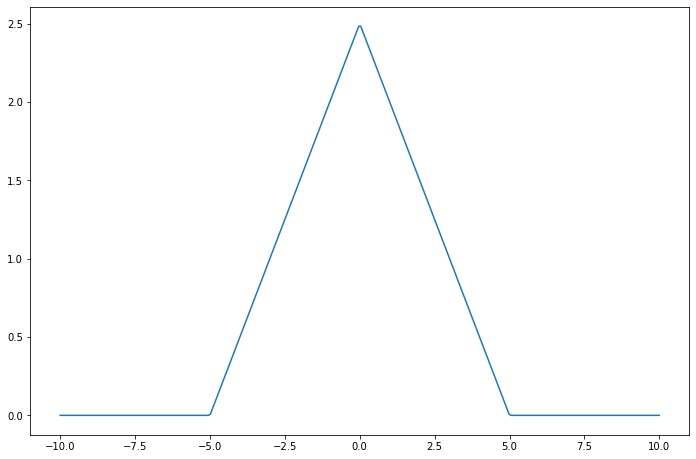

In [24]:
def init_1d(x):
    """ Non smooth bump around 0
    """
    return ( relu(x + 5) - 2 * relu(x) + relu(x - 5) ) / 2

X = np.linspace(start=-10, stop=10, num=300).astype(np.float32)
Y = init_1d(X)
plt.plot(X, Y)
plt.show()

A solução dessa equação pode ser representada como uma convolução da condição inicial com o kernel de uma gaussiana.

Computacionalmente, entretanto, decidimos calculá-la utilizando um resultado de cálculo estocástico segundo o qual a solução dessa equação é dada por
\begin{equation}
    u ( t, x ) = \mathbb{E} [u_0 ( x + B_t )]
,\end{equation}
onde $ B_t $ é o movimento browniano uni-dimensional.

O cálculo dessa esperaça é feito com um método Monte-Carlo simples, utilizando o fato de que $ B_t \sim \mathcal{N} ( 0, t ) $.

In [7]:
n = int(1e5)
B_1d = np.random.normal(size=n).astype(np.float32)

def expect_brownian_1d(g, t, x):
    """ Returns an approximation to E [g(x + B_t)], where B_t is
        the standard brownian motion.
    """
    points = x.shape[0]
    return tf.reduce_mean(g(x + np.sqrt(t) * B_1d), axis=1)

def sol_1d(t, x):
    """ Exact solution to pde. Implemented as an expectation
        of the Brownian Motion.
    """
    return expect_brownian_1d(init_1d, t, x)

Vamos plotar essa solução para alguns valores de $ t $ e entender como ela se comporta.

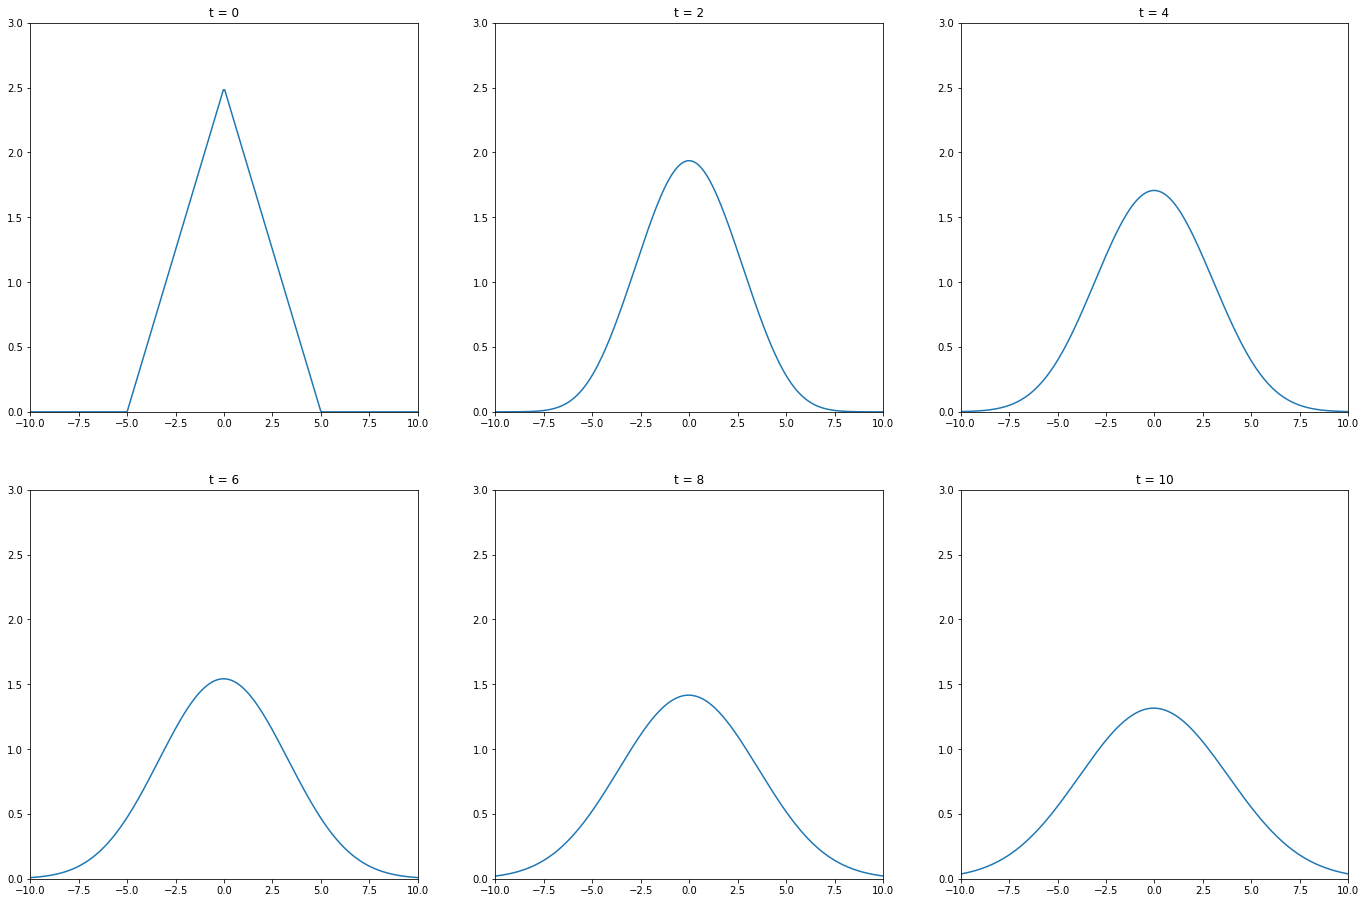

In [8]:
fig = plt.figure(figsize=(60*cent, 40*cent))
for fig_num, t in enumerate(np.arange(0, 11, step=2)):
    ax = fig.add_subplot(2, 3, fig_num+1)
    ax.set_ylim(0, 3)
    ax.set_xlim([-10, 10])
    Y = sol_1d(t, np.expand_dims(X, axis=1))
    ax.title.set_text(f"t = {t}")
    ax.plot(X, Y)


Agora definimos nossa EDP:

In [9]:
pde_1d = DiffusionPDE(dim=1,
                      t_max=t_max_1d,
                      domain=dom_1d,
                      solution=sol_1d,
                      initial_cond=init_1d,
                      kernel=kernel_1d,
                      name=f"heat_1D")

Com isso, podemos definir e treinar nosso modelo.

Aqui utilizamos as sugestões de arquitetura e de decaimento de learning rate dadas pelo artigo.

In [10]:
model = DGMNet(layer_width=50, n_layers=3, pde=pde_1d)
model.compile(optimizer="Adam")
model_path = f"./models/{pde_1d.name}/dgm"
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [5e3, 1e4, 2e4, 3e4, 4e4, 4.5e4],
    [1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 5e-7, 1e-7]
)

## Fit model / Load weights

# Load weights
model.load_weights(model_path)

# Fit
# model.fit(learning_rate_fn=learning_rate_fn,
#           epochs=1, # Times to go through each sample
#           sample_size=2**10,
#           sampling_stages=1400,
#           path=model_path)

Agora vamos plotar a solução do DGM:

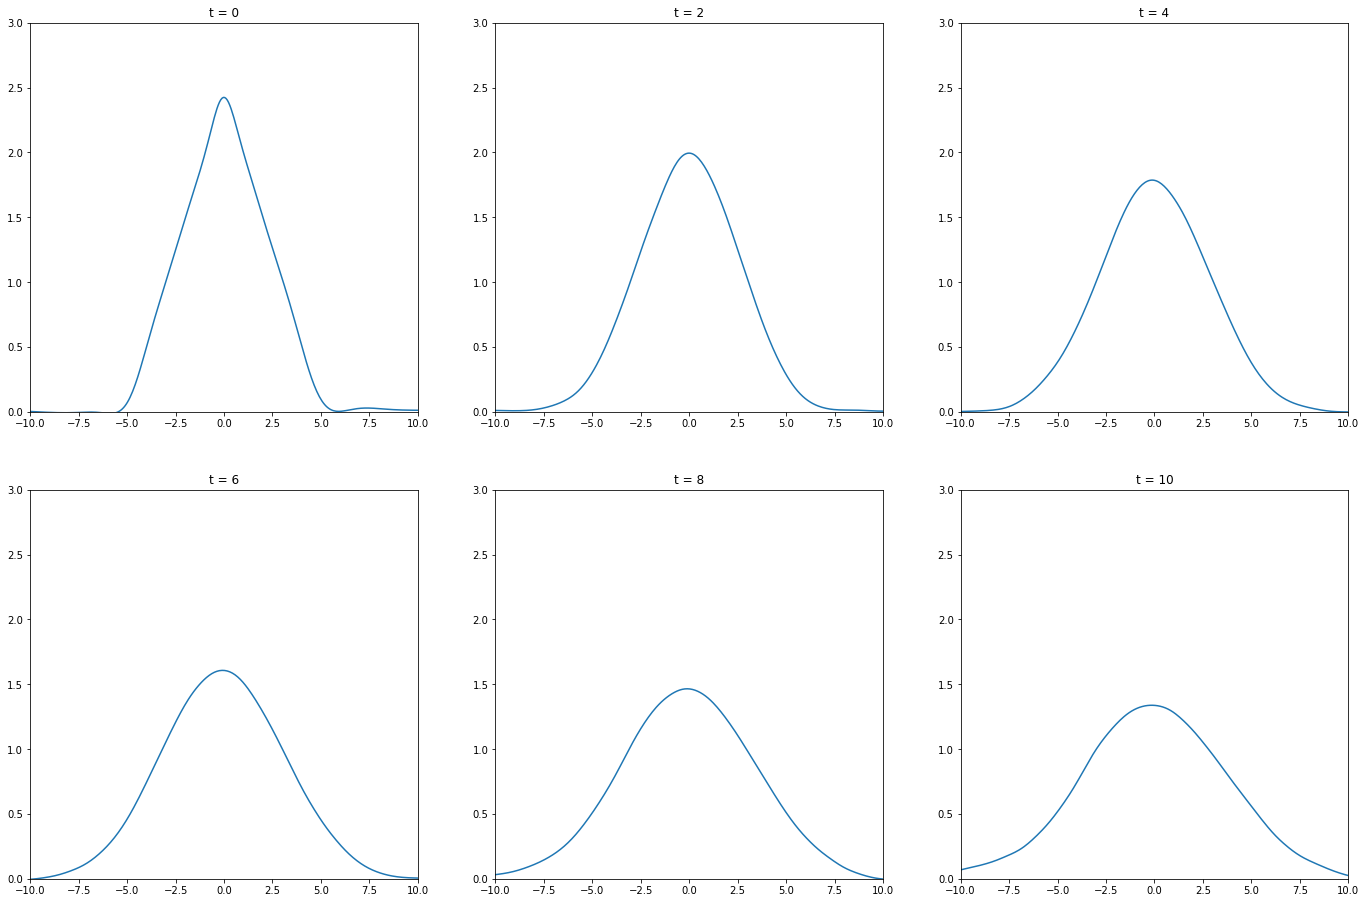

In [11]:
fig = plt.figure(figsize=(60*cent, 40*cent))
for fig_num, t in enumerate(np.arange(0, 11, step=2)):

    X_input = np.expand_dims(X, 1).astype(np.float32)
    t_input = t * np.ones_like(X_input).astype(np.float32)
    Y = tf.reshape(model(t_input, X_input), shape=(-1,))
    
    ax = fig.add_subplot(2, 3, fig_num+1)
    ax.set_ylim(0, 3)
    ax.set_xlim([-10, 10])
    ax.title.set_text(f"t = {t}")
    ax.plot(X, Y)

Plotando o erro:

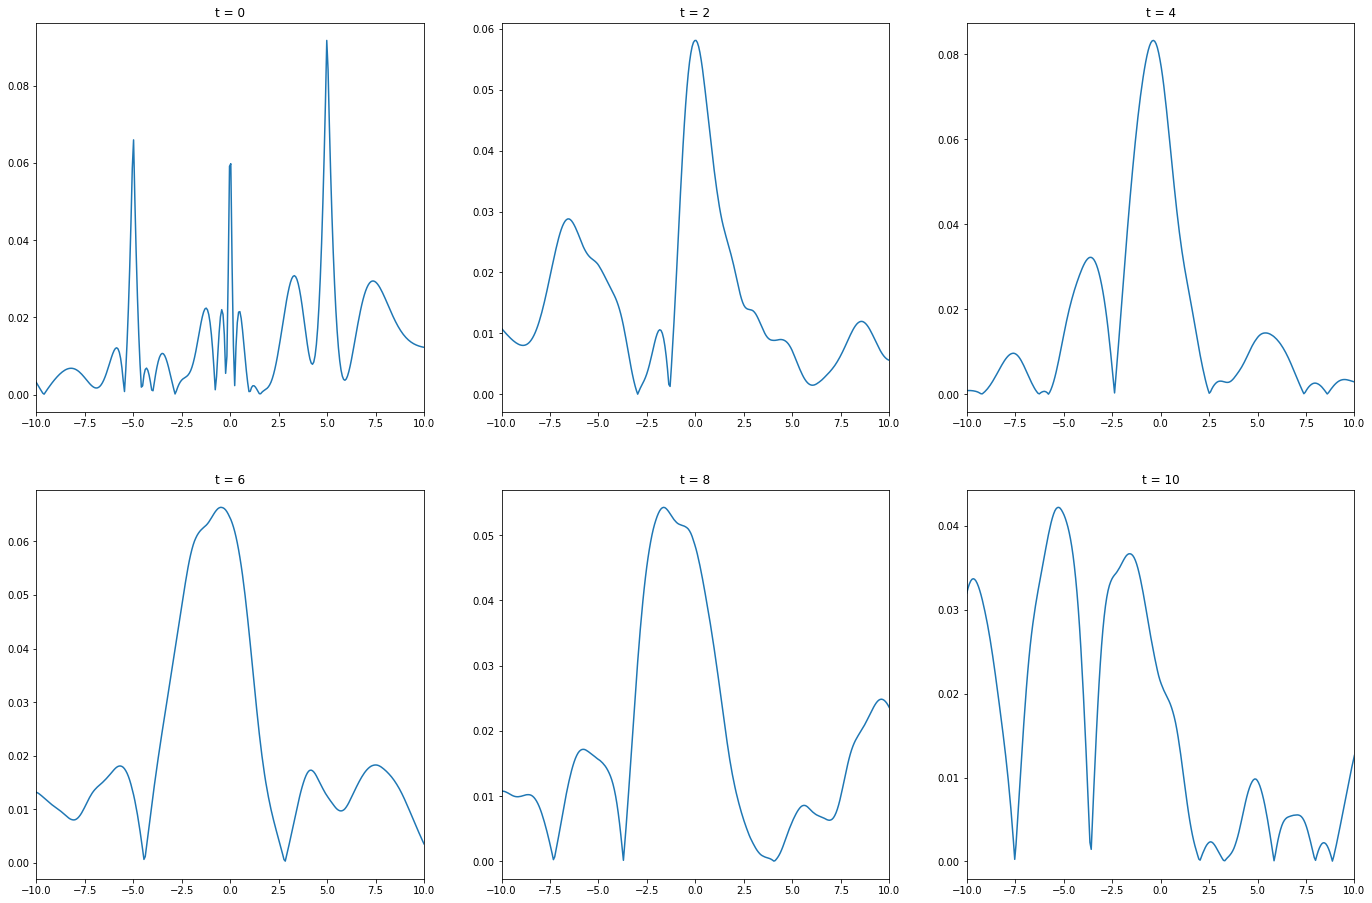

In [12]:
fig = plt.figure(figsize=(60*cent, 40*cent))
for fig_num, t in enumerate(np.arange(0, 11, step=2)):

    X_input = np.expand_dims(X, 1).astype(np.float32)
    t_input = t * np.ones_like(X_input).astype(np.float32)
    Y_dgm = tf.reshape(model(t_input, X_input), shape=(-1,))
    Y_true = sol_1d(t, np.expand_dims(X, 1))
    
    ax = fig.add_subplot(2, 3, fig_num+1)
    ax.set_xlim([-10, 10])
    ax.title.set_text(f"t = {t}")
    ax.plot(X, tf.math.abs(Y_true - Y_dgm))


# **2D Heat equation**
---------------------------------

Vamos resolver a EDP do calor com $ d = 2 $ e $ k = 1/2 $:
\begin{equation}
    \frac{ \partial u }{ \partial t } =
    \frac{ 1 }{ 2 } \left(
        \frac{ \partial^2 u }{ \partial x_1^2 } + \frac{ \partial^2 u }{ \partial x_2^2 }
        \right)
\end{equation}

Aqui, tomaremos $ L = 100 $ e $ T = 12 $.

In [13]:
dom_2d = np.array([[-L, L], [-L, L]])
kernel_2d = k * np.ones(shape=(2, 1))
t_max_2d = 12

n_points = 100 # for plottin purposes

Nossa condição inicial será uma aproximação contínua da seguinte função descontínua:
\begin{equation}
    u_0 ( x_1, x_2 ) = h \cdot \chi_{ (0, +\infty) } ( r^2 - x_1^2 - x_2^2 )
,\end{equation}
onde $ \chi_{ (0, +\infty) } $ é a função indicadora do intervalo $ (0, +\infty) $.

Ou seja, a temperatura inicial é $ h $ em um disco de raio $ r $ centrado na origem, e $ 0 $ fora dele.

A descontinuidade vem da função indicadora.
Entretanto, podemos aproximá-la continuamente com uma versão "espremida" da sigmoide:
\begin{equation}
    \sigma_s ( x ) = \frac{ 1 }{ 1 + e^{ -s x } }, s > 1
.\end{equation}

Visualmente:

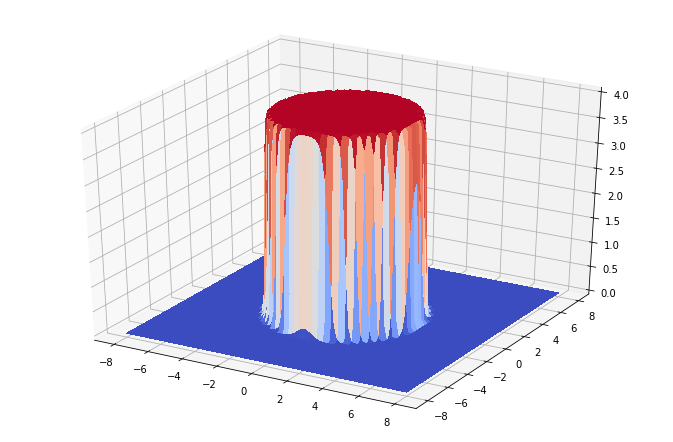

In [25]:
def indicator(x):
    """ Continuos approximation to the indicator function of the interval
        (0, +inf)
    """
    scale = 3
    return tf.math.sigmoid(scale * x)

def init_2d(x):
    """ Circular bump centered at the origin
        We assume that x is a (N, 2) shaped tensor
        Output has shape (N, 1)
    """
    radius = 4
    height = 4
    return height * indicator(radius**2 - tf.reduce_sum(tf.math.pow(x, 2),
                                                        axis=1,
                                                        keepdims=True))

X_lin = np.linspace(start=-8, stop=8, num=n_points)
Y_lin = np.linspace(start=-8, stop=8, num=n_points)
X_grid, Y_grid = np.meshgrid(X_lin, Y_lin)

# Stretched cartesian product used as input
xy_input = np.dstack(np.meshgrid(X_lin, Y_lin)).reshape(-1, 2).astype(np.float32)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
Z_grid_init = tf.reshape(init_2d(xy_input), shape=(n_points, n_points))
ax.plot_surface(X_grid, Y_grid, Z_grid_init, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()


A solução também é dada pela mesma equação:
\begin{equation}
    u (t, \boldsymbol{ x }) = \mathbb{E} [ u_0 ( \boldsymbol{x} + \boldsymbol{B}_t) ]
,\end{equation}
onde $ \boldsymbol{ B }_t $ é o movimento browniano bi-dimensional com entradas independentes.

In [15]:
n = int(1e4)
B_2d = np.random.normal(size=(n * n_points**2, 2)).astype(np.float32)

def expect_brownian_2d(g, t, x):
    """
        x: Tensor
            shape (N, 2)
        t: float32
        g: function
    """
    points = x.shape[0]
    expanded_x = tf.repeat(x, [n], axis=0)
    end = tf.reshape(g(expanded_x + np.sqrt(t) * B_2d), shape=(points, n))
    return tf.reduce_mean(end, axis=1)

def sol_2d(t, x):
    """
        x: Tensor
            shape (N, 2)
        t: float32
    """
    return expect_brownian_2d(init_2d, t, x)

Vamos plotar essa solução para alguns valores de $ t $ e ver como ela se comporta.

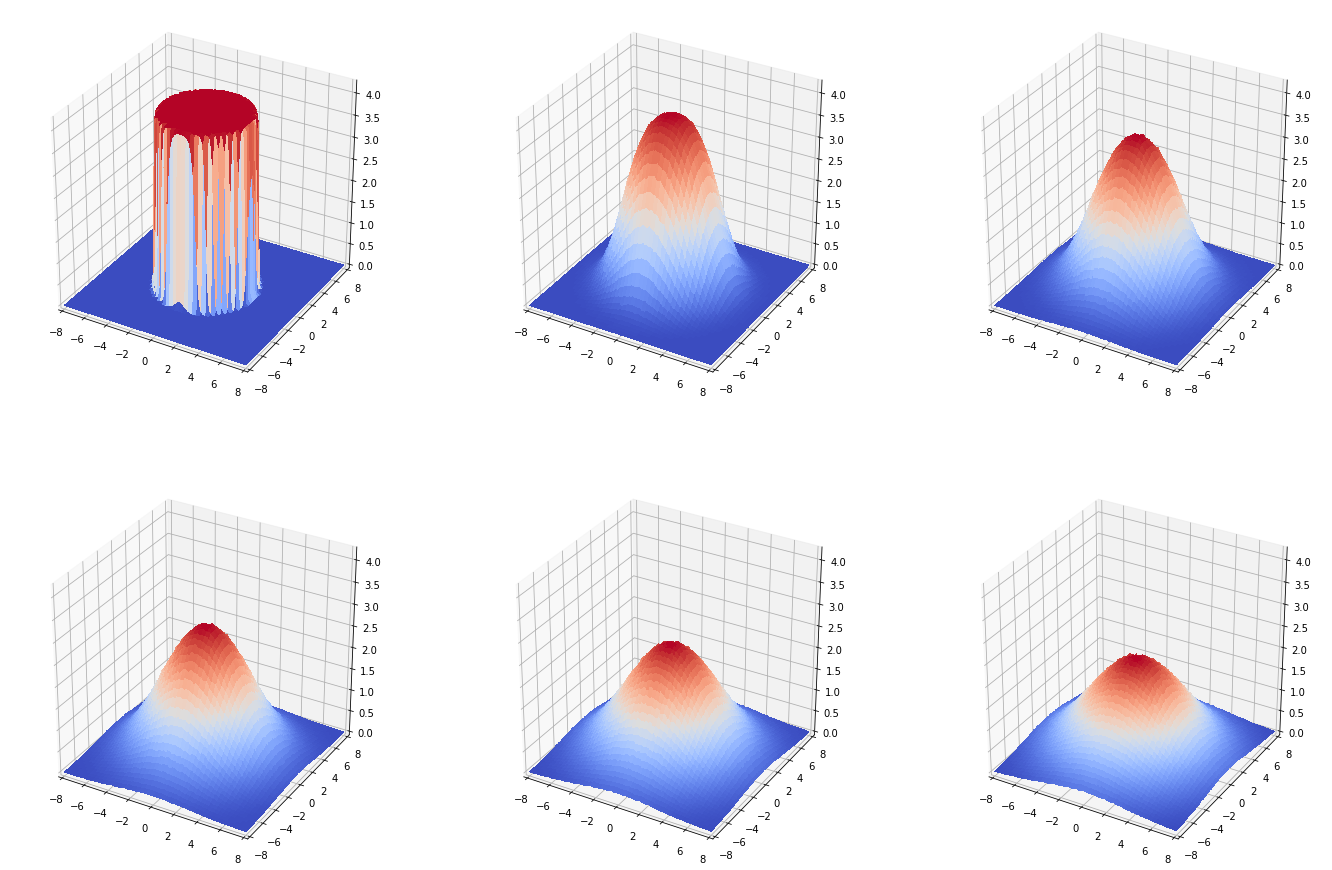

In [16]:
fig = plt.figure(figsize=(60*cent, 40*cent)) # 2 tall 3 wide

for fig_num, t in enumerate(np.arange(0, 11, 2)):

    Z_true = sol_2d(t, xy_input)

    Z_grid_true = tf.reshape(Z_true, shape=(n_points, n_points))

    ax = fig.add_subplot(2, 3, fig_num + 1, projection="3d")
    ax.set_zlim(0, 4.2)
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    
    ax.plot_surface(X_grid, Y_grid, Z_grid_true, cmap=cm.coolwarm, linewidth=0, antialiased=False)

plt.show()

Com isso, podemos instanciar a equação:

In [17]:
pde_2d = DiffusionPDE(dim=1,
                      t_max=t_max_2d,
                      domain=dom_2d,
                      solution=sol_2d,
                      initial_cond=init_2d,
                      kernel=kernel_2d,
                      name=f"heat_2D")

Agora vamos instanciar o modelo e treiná-lo.

In [20]:
model_2d = DGMNet(layer_width=50, n_layers=3, pde=pde_2d)
model_2d.compile(optimizer="Adam")
model_path_2d = f"./models/{pde_2d.name}/dgm"
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [5e3, 1e4, 2e4, 3e4, 4e4, 4.5e4],
    [1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 5e-7, 1e-7]
)

## Fit model / Load weights

# Load weights
model_2d.load_weights(model_path_2d)

# Fit
# model_2d.fit(learning_rate_fn=learning_rate_fn,
#              epochs=1, # Times to go through each sample
#              sample_size=2**10,
#              sampling_stages=int(1e4),
#              path=model_path_2d)

training loss of value func at step 0: L_diff: 0.05866790935397148, L_initial: 14.000436782836914
average sample time through last 1 samples: 27.64234757423401
average epoch time through last 1 epochs: 27.642340421676636
--------------------------------------------------
training loss of value func at step 100: L_diff: 0.01354299858212471, L_initial: 0.009945624507963657
average sample time through last 100 samples: 0.20323705434799194
average epoch time through last 100 epochs: 0.2032296586036682
--------------------------------------------------
training loss of value func at step 200: L_diff: 0.008796501904726028, L_initial: 0.0021661538630723953
average sample time through last 100 samples: 0.20542264699935914
average epoch time through last 100 epochs: 0.20541514635086058
--------------------------------------------------
training loss of value func at step 300: L_diff: 0.006072835065424442, L_initial: 0.001532776397652924
average sample time through last 100 samples: 0.2049346661

Vamos ver como está a solução:

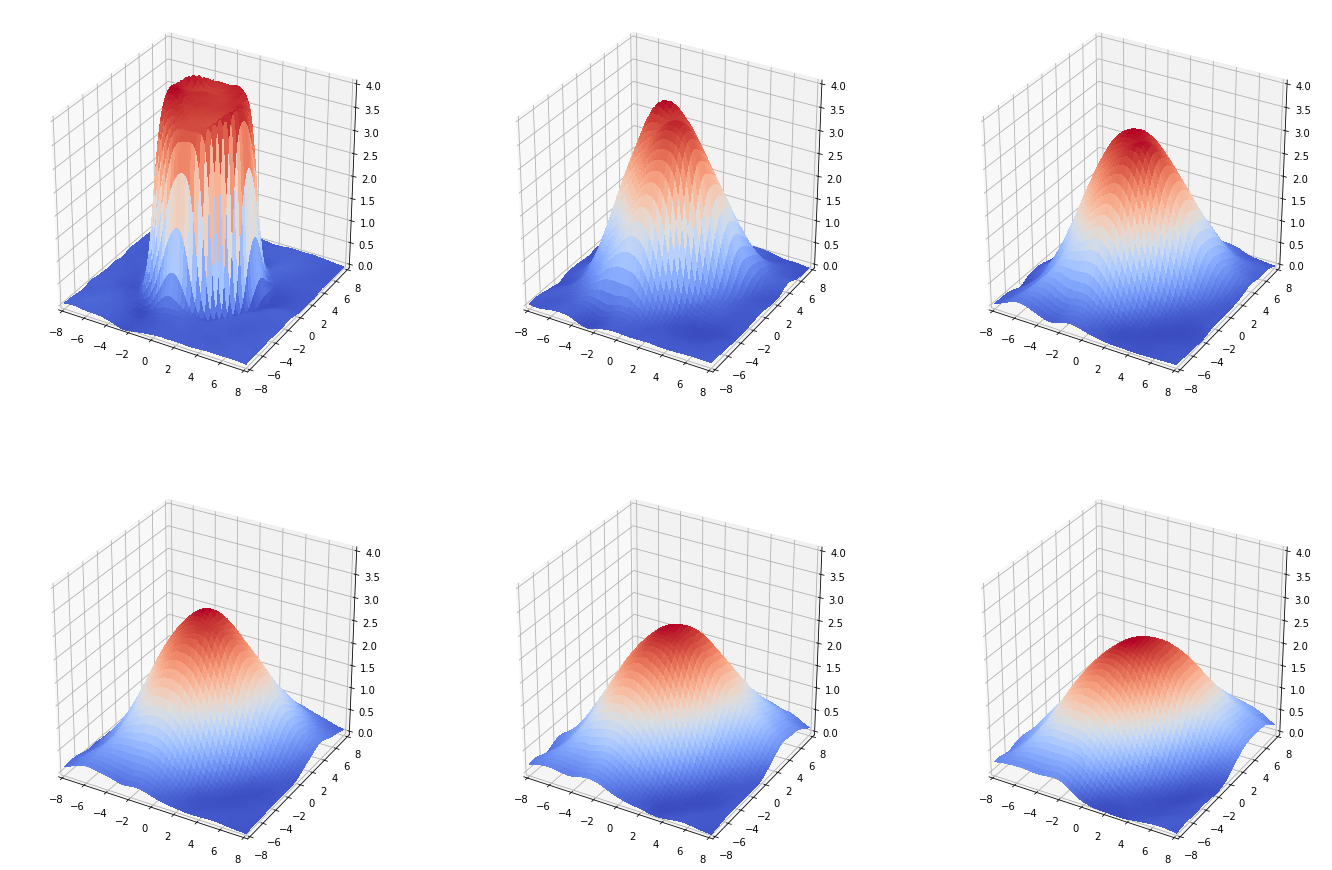

In [21]:
fig = plt.figure(figsize=(60*cent, 40*cent)) # 2 tall 3 wide

for fig_num, t in enumerate(np.arange(0, 11, 2)):

    t_input = (t * np.ones(shape=(n_points**2, 1))).astype(np.float32)

    Z_dgm = model_2d(t_input, xy_input)

    Z_grid_dgm = tf.reshape(Z_dgm, shape=(n_points, n_points))

    ax = fig.add_subplot(2, 3, fig_num + 1, projection="3d")
    ax.set_zlim(0, 4)
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    
    ax.plot_surface(X_grid, Y_grid, Z_grid_dgm, cmap=cm.coolwarm, linewidth=0, antialiased=False)